### Firing rate stability

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sessions = subjects.sd.ratVday2


In [7]:
frate_df = pd.DataFrame()
for neuron_type in ["pyr", "inter"]:
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"].flatten()
        post = sess.paradigm["post"].flatten()
        neurons = sess.neurons.get_neuron_type('pyr')
        pre_frate = neurons.time_slice(*pre).firing_rate
        post_frate =neurons.time_slice(*post).firing_rate

(0.001, 10)

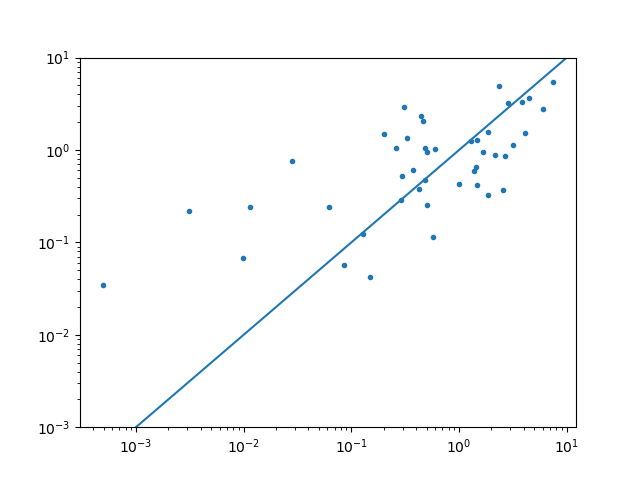

In [9]:
%matplotlib widget

plt.plot(pre_frate,post_frate,'.')
plt.yscale('log')
plt.xscale('log')
plt.axline((0,0),(1,1))
plt.ylim([0.001,10])

### Mean firing rate (taking mean across session)
- z-score each neuron's firing rate individually --> take mean of zscores within session --> take mean of means across session

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sessions = (
    subjects.sd.allsess[2:-1]
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)
print(sessions)


In [ ]:
frate_df = pd.DataFrame()
for neuron_type in ["pyr", "inter"]:
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"].flatten()
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm["post"].flatten()
        rec_duration = sess.eegfile.duration
        neurons = sess.neurons.get_neuron_type(neuron_type)

        bin_size = 60
        bin_spk_pre = neurons.time_slice(pre[0], maze[1]).get_binned_spiketrains(
            bin_size=bin_size
        )
        bin_spk_post = neurons.time_slice(
            maze[1], maze[1] + 9 * 3600
        ).get_binned_spiketrains(bin_size=bin_size)

        bins = np.arange(-bin_spk_pre.n_bins, bin_spk_post.n_bins) * (60 / 3600)
        spkcounts = np.hstack((bin_spk_pre.spike_counts, bin_spk_post.spike_counts))
        spkcounts = gaussian_filter1d(spkcounts, sigma=5, axis=-1)
        frate = spkcounts / bin_size
        frate_zscore = stats.zscore(frate, axis=1)
        mean_frate = np.mean(frate_zscore, axis=0)
        # mean_frate = gaussian_filter1d(mean_frate,sigma=2)
        frate_df = frate_df.append(
            pd.DataFrame(
                {
                    "bins": bins,
                    "frate": mean_frate,
                    "neuron_type": neuron_type,
                    "sub": sub,
                    "grp": sess.tag,
                }
            ),
            ignore_index=True,
        )


In [ ]:
%matplotlib widget
figure = Fig()
fig,gs = figure.draw(grid=(3,1))

for i,df in enumerate([sd_df,nsd_df]):
    mean_frate = df.groupby('bins').mean()
    x = mean_frate.index
    y = mean_frate.frate.values
    err = df.groupby('bins').sem(ddof=0).frate.values


    ax = plt.subplot(gs[i])
    # ax.errorbar(mean_frate.index,mean_frate.frate,sem_frate.frate)
    ax.fill_between(x,y-err,y+err,color='#c4c1ba')
    ax.plot(x,y,'k',lw=1)
    ax.axvline(0,ls='--')
    ax.axvline(-60,ls='--',color='r')
    ax.axvline(300,ls='--',color='k')
    ax.set_xlabel('Time bins from end of MAZE (bin size = 60 s)')
    # sns.lineplot(data=df,x='bins',y='frate',ci=68,ax=ax,palette='k')
    ax.set_ylabel('Normalized firing rate')


### Mean firing rate (taking mean across all cells)
- z-score each neuron's firing rate individually --> take mean of normalized firing rates across all cells from all sessions
- Analysis in response to Kamran's comment as observed from Miyawaki and Diba 2016 (Fig 1C)
> The animal is put on the track at 6am, and firing rates shoot up. In POST (next day’s light cycle) they start to come down. What happens to these firing rates in SD? In SD before Track, are they also high, or does it require TRack running?  And in NSD after track, do they come down, compared to SD after track?
- Here all types: pyr, inter, and mua are plotted together
- **Results**: It seems pyramidal neurons increase firing rate slightly across sleep deprivation
- **ToDo**: Should account for unstable cells, these maybe causing increased firing rate toward ZT5 in NSD sessions 


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sessions = (
    subjects.sd.allsess[2:-1]
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)
print(sessions)


[ProcessData(RatN_Day1_2019-10-09_03-52-32.xml)
, ProcessData(RatS_Day3SD_2020-11-29_07-53-30.xml)
, ProcessData(RatR_Day2SD_2021-05-23_09-07-18.xml)
, ProcessData(RatU_Day4SD_2021-07-29_08-23-06.xml)
, ProcessData(RatN_Day2_2019-10-11_03-58-54.xml)
, ProcessData(RatS-Day2NSD-2020-11-27_10-22-29.xml)
, ProcessData(RatU_Day2NSD_2021-07-24_08-16-38.xml)
]


In [ ]:
from neuropy.analyses import neurons_stability

frate_df_pooled = pd.DataFrame()
for neuron_type in ["pyr", "inter",'mua']:
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"].flatten()
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm["post"].flatten()
        rec_duration = sess.eegfile.duration
        neurons = sess.neurons.get_neuron_type(neuron_type)
        neurons_stable_bool = neurons_stability.firing_rate_stability(
            neurons=neurons, window=4 * 3600
        )
        neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

        bin_size = 60
        bin_spk_pre = neurons.time_slice(pre[0], maze[1]).get_binned_spiketrains(
            bin_size=bin_size
        )
        bin_spk_post = neurons.time_slice(
            maze[1], maze[1] + 9 * 3600
        ).get_binned_spiketrains(bin_size=bin_size)

        bins = np.arange(-bin_spk_pre.n_bins, bin_spk_post.n_bins) * (60 / 3600)
        spkcounts = np.hstack((bin_spk_pre.spike_counts, bin_spk_post.spike_counts))
        spkcounts = gaussian_filter1d(spkcounts, sigma=5, axis=-1)
        frate = spkcounts / bin_size
        frate_zscore = stats.zscore(frate, axis=1)

        frate_flat = frate_zscore.flatten()
        bin_flat = np.tile(bins, (neurons.n_neurons, 1)).flatten()

        # mean_frate = np.mean(frate_zscore, axis=0)
        # mean_frate = gaussian_filter1d(mean_frate,sigma=2)

        frate_df_pooled = frate_df_pooled.append(
            pd.DataFrame(
                {
                    "bins": bin_flat,
                    "frate": frate_flat,
                    "neuron_type": neuron_type,
                    "sub": sub,
                    "grp": sess.tag,
                }
            ),
            ignore_index=True,
        )

In [ ]:
%matplotlib widget
from neuropy import plotting

figure = plotting.Fig()
fig,gs = figure.draw(grid=(3,2))

neuron_colors = ['#f52e14','#0a8a46','#a7aeab']
gs_frate = figure.subplot2grid(gs[1, :], grid=(1, 2), wspace=0.15)
for i, neuron_type in enumerate(["pyr",'inter','mua']):

    neur_color = neuron_colors[i]

    for i1, (grp, grp_color) in enumerate(
        zip(
            ["sd", "nsd"],
            [
                "#df670c",
                "#633bb5",
            ],
        )
    ):
        ax_frate = plt.subplot(gs[i1])
        df = frate_df_pooled[
            (frate_df_pooled["grp"] == grp)
            & (frate_df_pooled["neuron_type"] == neuron_type)
        ]

        mean_frate = df.groupby("bins").mean()
        x = mean_frate.index
        y = mean_frate.frate.values
        err = df.groupby("bins").sem(ddof=0).frate.values
        ax_frate.fill_between(
            x, y - err, y + err, color=neur_color, alpha=0.3, ec=None, zorder=1
        )
        ax_frate.plot(x, y, neur_color, lw=1, zorder=2)

        ax_frate.set_title(f"{grp.upper()} sessions", loc="left")
        # baseline=====
        df_pre = frate_df_pooled[frate_df_pooled["bins"] < -1]
        df_pre_mean = df_pre.groupby("bins").mean().mean().frate
        ax_frate.axhline(df_pre_mean, ls="--", color="gray")
        ax_frate.axvspan(-4.2, 0, 0, 0.05, color="#6d6d69")
        ax_frate.axvspan(0, 9, 0, 0.05, color="#e6e6a2")
        ax_frate.set_xlabel("ZT time (h)")
        ax_frate.set_xlim(left=-4.2)
        ax_frate.axvspan(
            -4, -1, 0.2, 0.25, color="#cdd0cd", alpha=0.5, zorder=0, ec=None
        )
        ax_frate.text(-3, -0.52, "PRE", fontsize=8)
        ax_frate.axvspan(
            -1, 0, 0.2, 0.25, color="#68c563", alpha=0.5, zorder=0, ec=None
        )
        ax_frate.text(-1.1, -0.52, "MAZE", fontsize=8)
        ax_frate.axvspan(0, 9, 0.2, 0.25, color="#cdd0cd", alpha=0.5, zorder=0, ec=None)
        ax_frate.text(4, -0.52, "POST", fontsize=8)
        ax_frate.set_xlim([-4, 9])

        # ax_frate.axvline(0,ls='--',color='gray')
        # ax_frate.axvline(5,ls='--',color='gray')

        if i1 == 0:
            ax_frate.text(2, 0.5, "SD", fontsize=8)
            ax_frate.text(7, 0.5, "RS", fontsize=8)
            ax_frate.axvspan(
                0, 5, 0.8, 0.85, color="#f9951a", alpha=0.5, zorder=0, ec=None
            )
            ax_frate.axvspan(
                5, 9, 0.8, 0.85, color="#f19de9", alpha=0.5, zorder=0, ec=None
            )
            ax_frate.set_ylabel("Normalized firing rate")
            figure.panel_label(ax_frate, "C")

        ax_frate.set_ylim([-1.2, 1.6])


# figure.savefig(subjects.figpath_sd/'firing_rate_across_sessions')

### Firing rate change at NREM-REM transition during recovery sleep vs regular sleep
There can be two ways to look at the changes in firing rate
- mua firing rate (but it does not make sense, as high firing rate neurons can blur the changes)
- normalize/zscore each neurons firing rate during transition and then calculate the mean across neurons 
    - firing rate increase towards the end of NREM and decrese during following REM. This is consistent with Miyawaki and Diba (2016)

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]


In [ ]:
df = pd.DataFrame()
binsz = 2
for sess_ind, sessions in enumerate([sessions_sd, sessions_nsd]):
    grp = "sd" if sess_ind == 0 else "nsd"
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"]
        pyr = sess.neurons.get_neuron_type("pyr")
        rec_slp = [post[0] + 5 * 3600, post[1]]
        states = sess.brainstates.time_slice(rec_slp[0], rec_slp[1]).to_dataframe()
        labels = states.label.values

        for i in range(len(labels) - 1):
            if (labels[i] == "nrem") and (labels[i + 1] == "rem"):

                # ---- MUA -----
                # nrem_mua = pyr.get_mua(t_start=states.iloc[i].start,t_stop=states.iloc[i].stop,bin_size=4)
                # rem_mua = pyr.get_mua(t_start=states.iloc[i+1].start,t_stop=states.iloc[i+1].stop,bin_size=4)
                # frate = np.hstack((nrem_mua.spike_counts,rem_mua.spike_counts))
                # bins = np.arange(-nrem_mua.n_bins,rem_mua.n_bins)

                # --- zscored firing rate ---------
                nrem_binspk = pyr.get_binned_spiketrains(
                    t_start=states.iloc[i].start,
                    t_stop=states.iloc[i].stop,
                    bin_size=binsz,
                )
                rem_binspk = pyr.get_binned_spiketrains(
                    t_start=states.iloc[i + 1].start,
                    t_stop=states.iloc[i + 1].stop,
                    bin_size=binsz,
                )
                bins = np.arange(-nrem_binspk.n_bins, rem_binspk.n_bins)
                frate = np.nanmean(
                    stats.zscore(
                        np.hstack((nrem_binspk.spike_counts, rem_binspk.spike_counts)),
                        axis=1,
                    ),
                    axis=0,
                )

                df = df.append(pd.DataFrame({"bins": bins, "frate": frate, "grp": grp}))


In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(5,4),style='Pres')
ax = plt.subplot(gs[0])
df_ = df.groupby('grp')
color = ['r','k']
for i,grp in enumerate(['sd','nsd']):
    grp_df = df_.get_group(grp)
    mean_frate = grp_df.groupby('bins').mean().frate
    sem_frate = grp_df.groupby('bins').sem(ddof=0).frate
    ax.fill_between(mean_frate.index.values,mean_frate-sem_frate,mean_frate+sem_frate,color=color[i],alpha=0.3,ec=None)
    ax.plot(mean_frate.index.values,mean_frate,color=color[i],alpha=0.6)
    # ax.errorbar(mean_frate.index,mean_frate, yerr=sem_frate,color=color[i],capsize=3,elinewidth=1,errorevery=1)
    # ax = sns.lineplot(data=df,x='bins',y='mua',ci='sd')

ax.legend(['sd rec. slp.','nsd'])
ax.axvline(x=0,ls='--')
ax.set_xlim([-50,30])
ax.set_ylim([-0.4,0.4])
ax.set_title('NREM-REM transition')
ax.set_ylabel('Normalized firing rate')
ax.set_xlabel('Time bin from start of REM')
figure.savefig('nrem-rem_transition_frate_sd_vs_nsd',folder='/home/bapung/Documents/figures')


### Firing rate changes within NREM during and SD and compare with NSD
- Firing rate first decreases and then increases ? Not consistent with Miyawaki and Diba 2016 ?

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]
print(sessions_sd,sessions_nsd)


In [ ]:
df = pd.DataFrame()
for sess_ind, sessions in enumerate([sessions_sd, sessions_nsd]):
    grp = "sd" if sess_ind == 0 else "nsd"
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"]
        pyr = sess.neurons.get_neuron_type("pyr")
        rec_slp = [post[0] + 5 * 3600, post[1]]
        states = sess.brainstates.time_slice(rec_slp[0], rec_slp[1]).to_dataframe()
        labels = states.label.values
        nrems = states[(states["label"] == "nrem") & (states["duration"] > 240)]

        for nrem in nrems.itertuples():

            bins, binsz = np.linspace(nrem.start, nrem.stop, 10, retstep=True)

            nrem_binspk = pyr.get_binned_spiketrains(
                t_start=nrem.start, t_stop=nrem.stop, bin_size=binsz
            )

            frate = np.nanmean(stats.zscore(nrem_binspk.spike_counts, axis=1), axis=0)

            df = df.append(
                pd.DataFrame(
                    {"bins": np.linspace(0,1,nrem_binspk.n_bins), "frate": frate, "grp": grp}
                )
            )

In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(5,4),style='Pres')
ax = plt.subplot(gs[0])
df_ = df.groupby('grp')
color = ['#26507e','#79a7d7']
z=1
for i,grp in enumerate(['sd','nsd']):
    grp_df = df_.get_group(grp)
    mean_frate = grp_df.groupby('bins').mean().frate
    sem_frate = grp_df.groupby('bins').sem(ddof=0).frate
    ax.fill_between(mean_frate.index.values,mean_frate-sem_frate,mean_frate+sem_frate,color=color[i],alpha=0.3,ec=None,zorder=z)
    ax.plot(mean_frate.index.values,mean_frate,color=color[i],zorder=z+1)
    # ax.errorbar(mean_frate.index,mean_frate, yerr=sem_frate,color=color[i],capsize=3,elinewidth=1,errorevery=1)
    # ax = sns.lineplot(data=df,x='bins',y='mua',ci='sd')
    z+=2

ax.legend(['sd rec. slp.','nsd'])
ax.set_title('Firing rate changes within NREM')
ax.set_ylabel('Normalized firing rate')
ax.set_xlabel('Time bin from start of NREM')
figure.savefig(subjects.fig_folder/'nrem-rem_transition_frate_sd_vs_nsd')

### Firing rate changes across sleep deprivation individual neurons or quantiles
- something simiilar to firing rate homeostasis

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess[1:-1]
sessions_nsd = subjects.nsd.allsess[:-1]
print(sessions_sd,sessions_nsd)


In [ ]:
bin_size = 60
for sub,sess in enumerate(sessions_sd[2:3]):
    post = sess.paradigm['post']
    sd= [post[0],post[0]+5*3600]
    neurons =sess.neurons.get_neuron_type('pyr').time_slice(t_start=sd[0],t_stop=sd[1])
    binspk = neurons.get_binned_spiketrains(bin_size=bin_size)
    zsc_binspk = stats.zscore(binspk.spike_counts/bin_size,axis=1)

In [ ]:
%matplotlib widget
plt.plot(zsc_binspk[5:10,:].T)
# plt.yscale('log')

### Participation rate within ripples as function of sleep deprivation

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sd_sessions = subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions= subjects.nsd.ratSday2 + subjects.nsd.ratUday2
print(sd_sessions,nsd_sessions)

In [ ]:
for grp_ind,grp in enumerate([sd_sessions,nsd_sessions]):
    for sub,sess in enumerate(grp):
        rpl = sess.ripple

### Cells increasing their firing rate the most from pre to maze and dividing them into quantiles
- quantiles were estimated after pooling all the cells into a big group

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sd_sessions = subjects.sd.allsess[1:-1]
nsd_sessions =subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2 
print(sd_sessions)
print(nsd_sessions)

In [ ]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
for neuron_type in ["pyr"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        pre_to_maze = []
        post_frate = []
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"]
            maze = sess.paradigm["maze"]
            if maze.size == 0:
                maze = sess.paradigm["maze1"]
            post = sess.paradigm["post"]
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons, window=4 * 3600
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            f_rate = []
            for i, (t_start, t_end) in enumerate(
                zip([pre[0], maze[0]], [pre[1], maze[1]])
            ):
                f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

            f_rate = np.asarray(f_rate).T
            pre_to_maze.append(np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0])

            binspk = neurons.time_slice(
                post[0], post[0] + 5 * 3600
            ).get_binned_spiketrains(bin_size=bin_size)

            post_frate.append(binspk.spike_counts / bin_size)

        pre_to_maze = np.concatenate(pre_to_maze)
        post_frate = np.vstack(post_frate)

        quantiles = pd.qcut(pre_to_maze, q=nQuantiles, labels=False)
        quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
        quant_mean_frate = np.asarray(quant_mean_frate)
        first_bin = quant_mean_frate[:,0]
        quant_mean_frate = quant_mean_frate/first_bin[:,np.newaxis]

        df = pd.DataFrame(
            quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
        )
        df["grp"] = grp
        df['quantiles'] = np.arange(nQuantiles)
        frate_maze_vs_sd = frate_maze_vs_sd.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp",'quantiles'],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name='frate',
    ignore_index=True,
)

frate_maze_vs_sd['bins'] = frate_maze_vs_sd['bins']*(bin_size/3600)

In [ ]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw()

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs[i])
    df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp)]
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
    )
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.4,top=1.6)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    if i==0:
        figure.panel_label(ax_1v5,'E')



### Cells increasing their firing rate the most from pre to maze and dividing them into quantiles
- quantiles were estimated individually for each session

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sd_sessions = subjects.sd.ratNday1 + subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions =subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2 
print(sd_sessions)
print(nsd_sessions)

In [ ]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
frate_maze_vs_sd_shuffled = pd.DataFrame()
for neuron_type in ["pyr"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        # pre_to_maze = []
        post_frate = []
        quantiles = []
        sub_ind = []
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"]
            maze = sess.paradigm["maze"]
            if maze.size == 0:
                maze = sess.paradigm["maze1"]
            post = sess.paradigm["post"]
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons, window=4 * 3600
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            f_rate = []
            for i, (t_start, t_end) in enumerate(
                zip([pre[0], maze[0]], [pre[1], maze[1]])
            ):
                f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

            f_rate = np.asarray(f_rate).T
            # pre_to_maze.append(np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0])
            pre_to_maze = np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0]

            binspk = neurons.time_slice(
                post[0], post[0] + 5 * 3600
            ).get_binned_spiketrains(bin_size=bin_size)

            sess_post_frate = binspk.spike_counts/bin_size

            post_frate.append(sess_post_frate)

            # --- quantile categorization ---
            quantiles.append(pd.qcut(pre_to_maze, q=nQuantiles, labels=False))
            sub_ind.append(sub*np.ones(neurons.n_neurons))

        quantiles = np.concatenate(quantiles)
        post_frate = np.vstack(post_frate)
        assert len(quantiles) == post_frate.shape[0],'First dimension should match'

        quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]

        quant_mean_frate = np.asarray(quant_mean_frate)
        first_bin = quant_mean_frate[:, 0]
        quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

        df = pd.DataFrame(
            quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
        )
        df["grp"] = grp
        df["quantiles"] = np.arange(nQuantiles)
        frate_maze_vs_sd = frate_maze_vs_sd.append(df)

        #shuffles
        for i in range(100):
            quantiles_shuffle =quantiles.copy()  
            np.random.shuffle(quantiles_shuffle)
            quant_mean_frate = [
                np.nanmean(post_frate[quantiles_shuffle == q, :], axis=0) for q in range(nQuantiles)
            ]

            quant_mean_frate = np.asarray(quant_mean_frate)
            first_bin = quant_mean_frate[:, 0]
            quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

            df = pd.DataFrame(
                quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
            )
            df["grp"] = grp
            df["quantiles"] = np.arange(nQuantiles)
            frate_maze_vs_sd_shuffled = frate_maze_vs_sd_shuffled.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp", "quantiles",'sub'],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd["bins"] = frate_maze_vs_sd["bins"] * (bin_size / 3600)

frate_maze_vs_sd_shuffled = pd.melt(
    frate_maze_vs_sd_shuffled,
    id_vars=["grp", "quantiles"],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd_shuffled["bins"] = frate_maze_vs_sd_shuffled["bins"] * (bin_size / 3600)


#### Plotting all together

In [ ]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw(grid=(3,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs[i])
    df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp)]
    df_shuffled = frate_maze_vs_sd_shuffled[(frate_maze_vs_sd_shuffled["grp"] == grp)]
    sns.lineplot(
        data=df_shuffled,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=['#ababab']*5,
        legend=None,
        ax=ax_1v5,
        alpha = 0.5,
    )
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
        ax=ax_1v5
    )   
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.4,top=1.6)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    if i==0:
        figure.panel_label(ax_1v5,'E')

ax_caption = plt.subplot(gs[1, :])
ax_caption.text(
    0,
    0,
    "Figure: Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Gray curves denote firing rate changes if pentiles are randomly categorized (100 times).",
    wrap=True,
)
ax_caption.axis("off")

figure.savefig(subjects.figpath_sd/'pentiles_pre_to_maze_ZT5')

### Quantile firing rate
- Quantile firing rate changes but for each session individually.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sd_sessions = subjects.sd.ratNday1 + subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions =subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2 
print(sd_sessions)
print(nsd_sessions)

In [ ]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
frate_maze_vs_sd_shuffled = pd.DataFrame()

for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"]
        maze = sess.paradigm["maze"]
        if maze.size == 0:
            maze = sess.paradigm["maze1"]
        post = sess.paradigm["post"]
        rec_duration = sess.eegfile.duration
        neurons = sess.neurons.get_neuron_type(neuron_type)
        neurons_stable_bool = neurons_stability.firing_rate_stability(
            neurons=neurons, window=4 * 3600
        )
        neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

        f_rate = []
        for i, (t_start, t_end) in enumerate(
            zip([pre[0], maze[0]], [pre[1], maze[1]])
        ):
            f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

        f_rate = np.asarray(f_rate).T
        pre_to_maze = np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0]

        binspk = neurons.time_slice(
            post[0], post[0] + 9 * 3600
        ).get_binned_spiketrains(bin_size=bin_size)

        sess_post_frate = binspk.spike_counts/bin_size

        # --- quantile categorization ---

        quantiles= pd.qcut(pre_to_maze, q=nQuantiles, labels=False)
        assert len(quantiles) == sess_post_frate.shape[0],'First dimension should match'
        quant_mean_frate = [
            np.nanmean(sess_post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
        quant_mean_frate = np.asarray(quant_mean_frate)
        first_bin = quant_mean_frate[:, 0]
        quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

        df = pd.DataFrame(
            quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
        )
        df["grp"] = grp
        df["quantiles"] = np.arange(nQuantiles)
        df['sub'] = sub
        frate_maze_vs_sd = frate_maze_vs_sd.append(df)

    # #shuffles
    # for i in range(100):
    #     quantiles_shuffle =quantiles.copy()  
    #     np.random.shuffle(quantiles_shuffle)
    #     quant_mean_frate = [
    #         np.nanmean(post_frate[quantiles_shuffle == q, :], axis=0) for q in range(nQuantiles)
    #     ]

    #     quant_mean_frate = np.asarray(quant_mean_frate)
    #     first_bin = quant_mean_frate[:, 0]
    #     quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

    #     df = pd.DataFrame(
    #         quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
    #     )
    #     df["grp"] = grp
    #     df["quantiles"] = np.arange(nQuantiles)
    #     frate_maze_vs_sd_shuffled = frate_maze_vs_sd_shuffled.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp", "quantiles",'sub'],
    value_vars=np.arange(36),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd["bins"] = frate_maze_vs_sd["bins"] * (bin_size / 3600)

# frate_maze_vs_sd_shuffled = pd.melt(
#     frate_maze_vs_sd_shuffled,
#     id_vars=["grp", "quantiles"],
#     value_vars=np.arange(20),
#     var_name=["bins"],
#     value_name="frate",
#     ignore_index=True,
# )


# frate_maze_vs_sd_shuffled["bins"] = frate_maze_vs_sd_shuffled["bins"] * (bin_size / 3600)


In [ ]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw(grid=(4,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):

    for i1 in range(3):
        ax_1v5 = plt.subplot(gs[i1,i])
        df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp) & (frate_maze_vs_sd['sub']==i1)]
        sns.lineplot(
            data=df,
            x="bins",
            y="frate",
            hue="quantiles",
            palette=palette[i].hex_colors[1:],
            legend=None,
            ax=ax_1v5
        )   
        # ax_1v5.set_yscale('log')
        ax_1v5.axhline(1,ls='--',color='gray')
        ax_1v5.set_ylim(bottom=0.25,top=2.5)
        ax_1v5.set_ylabel('Firing rate ratio')
        ax_1v5.set_xlabel('Zt time (h)')
        if i==0:
            figure.panel_label(ax_1v5,'E')

# ax_caption = plt.subplot(gs[1, :])
# ax_caption.text(
#     0,
#     0,
#     "Figure: Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Gray curves denote firing rate changes if pentiles are randomly categorized (100 times).",
#     wrap=True,
# )
# ax_caption.axis("off")

# figure.savefig(subjects.figpath_sd/'pentiles_pre_to_maze_POST_individual')

### Scatter plot for firing rate in PRE/MAZE/POST1/POST5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

sessions

In [ ]:
frate_df = pd.DataFrame()
for sub,sess in enumerate(sessions):
    pre = sess.paradigm['pre'].flatten()
    maze = sess.paradigm['maze'].flatten()
    post= sess.paradigm['post'].flatten()

    pyr_neurons = sess.neurons.get_neuron_type('pyr')
    windows = [pre,maze,[post[0],post[0]+3600],[post[0]+4*3600,post[0]+5*3600]]

    frate=[]
    for window in windows:
        frate.append(pyr_neurons.time_slice(*window).firing_rate)
    df =pd.DataFrame(np.asarray(frate).T,columns=['pre','maze','post1h','post5h'])
    df['subject'] = sess.sub_name
    df['grp'] = sess.tag
    frate_df = frate_df.append(df)

# frate_df = pd.melt()
frate_df = pd.melt(
    frate_df,
    id_vars=["maze", "subject",'grp'],
    value_vars=['pre','post1h','post5h'],
    var_name=["epochs"],
    value_name="frate",
    ignore_index=True,
)



In [ ]:
%matplotlib widget

s = sns.lmplot(data=frate_df,x='maze',y='frate',row='grp',col='epochs')
[ax.set_xscale('log') for ax in s.axes.reshape(-1)]
[ax.set_yscale('log') for ax in s.axes.reshape(-1)]

### Interneuron ripple categorization and frate during SD
- It is hypothesized that PV and SOM interneurons fire differently during ripples (Diba et al. 2014, Cscisvari et al. 1999). So we asked if these types are also affected differently during sleep deprivation.
- **Results**: It seems they are similarly affected by prolonged wakefulness. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)

In [ ]:
from sklearn.cluster import KMeans
from ripple_funcs import ripple_modulation

frate_around_rpl, frate_session_all, grp_info = [], [], []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("inter")
    n_neurons = len(neurons)
    ripples = sess.ripple.to_dataframe()

    start, peak, stop = sess.ripple.to_dataframe()[
        ["start", "peaktime", "stop"]
    ].values.T

    modulation = ripple_modulation(neurons,start,peak,stop,n_bins=4) 

    frate_around_rpl.append(modulation)
    frate_session_all.append(
        neurons.time_slice(post[0], post[0] + 9 * 3600)
        .get_binned_spiketrains(5 * 60)
        .firing_rate
    )
    grp_info.extend([sess.tag] * n_neurons)


frate_session_all = np.vstack(frate_session_all)
frate_around_rpl = np.vstack(frate_around_rpl)
frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
kmeans = KMeans(n_clusters=2, random_state=0).fit(frate_norm)

bins = np.arange(-8,9)
frate_rpl_df = pd.DataFrame(frate_around_rpl, columns=bins.reshape(-1)[:-1])
frate_rpl_df["grp"] = grp_info

time_bin = np.arange(frate_session_all.shape[1]) * (300 / 3600)
frate_session_df = pd.DataFrame(stats.zscore(frate_session_all,axis=1), columns=time_bin)
frate_session_df["label"] = kmeans.labels_
frate_session_df["grp"] = grp_info

frate_session_df = pd.melt(
    frate_session_df,
    id_vars=["grp", "label"],
    value_vars=time_bin,
    var_name=["time"],
    value_name="frate",
    ignore_index=True,
)


In [ ]:
%matplotlib widget
import seaborn as sns

g = sns.relplot(
    data=frate_session_df,
    x="time",
    y="frate",
    hue="label",
    kind="line",
    ci=None,
    col="grp",
    palette=['r','k'],
    height=4,
    aspect=11/10
)

for ax in g.axes.reshape(-1):
    ax.axvline(5,ls='--',color='gray') 
# g.fig.savefig(subjects.figpath_sd/'interneuron_frate_POST_ripple_modulation.pdf')